In [170]:
import pandas as pd
import numpy as np
import itertools

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline 
from sklearn.compose import ColumnTransformer
from sklearn.metrics import f1_score, roc_auc_score, classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import (learning_curve, validation_curve, train_test_split, KFold, StratifiedKFold, 
                                    cross_val_score, GridSearchCV, RandomizedSearchCV, cross_validate, RepeatedStratifiedKFold)

from sklearn.linear_model import Perceptron, LogisticRegression
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import FunctionTransformer, StandardScaler, MinMaxScaler, OneHotEncoder, OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier

from sklearn.datasets import fetch_openml
from scipy.stats import loguniform, beta, uniform

from mlxtend.feature_selection import SequentialFeatureSelector as SFS

from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.pipeline import Pipeline as IMBPipeline

import missingno as msno

import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')

PIPELINE; is the union of several transformers or imputer - for nan values
SIMPLE IMPUTER: IF HAVE MISSING DATATS: FILL WITH MOST FREQUENT

ORDINAL ENCODER: AS ONEHOT BUT WITH ORDER - COL: GENDER(MALE - FEMALE) , TARTAR(Y - N) , ORAL (=> CAN BE DROPPED)

MINMAX SCALER OR STANDARD SCALER: FOR NUMERICAL DATAS: ALL COLUMNS with standard scaler


In [172]:
# Carichiamo il dataset
dataset = pd.read_csv("dataset_1")
dataset.info()

PermissionError: [Errno 13] Permission denied: 'C:\\Users\\loryb\\.cache\\kagglehub\\datasets\\kukuroo3\\body-signal-of-smoking\\versions\\2'

In [155]:
# if input("do you whant to finish quickly the project?(y/n):") == "y":
#     dataset.dropna(axis=1)
#     dataset.info()
#     print("well done, now 30L")
# else:
#     pass

In [156]:

# Analizziamo il bilanciamento della variabile target
sm = dataset["smoking"].value_counts(normalize=True)
print(f"Distribuzione della variabile target: {sm}")

# analizziamo la distribuzione dei Nan values:
for col in dataset:
    Nan=dataset[col].isnull().sum()
    print(f"missing values in {col}: {Nan}")


Distribuzione della variabile target: smoking
0    0.632712
1    0.367288
Name: proportion, dtype: float64
missing values in ID: 0
missing values in gender: 790
missing values in age: 0
missing values in height(cm): 934
missing values in weight(kg): 901
missing values in waist(cm): 933
missing values in eyesight(left): 596
missing values in eyesight(right): 833
missing values in hearing(left): 639
missing values in hearing(right): 640
missing values in systolic: 155
missing values in relaxation: 626
missing values in fasting blood sugar: 855
missing values in Cholesterol: 972
missing values in triglyceride: 344
missing values in HDL: 113
missing values in LDL: 717
missing values in hemoglobin: 948
missing values in Urine protein: 150
missing values in serum creatinine: 674
missing values in AST: 492
missing values in ALT: 72
missing values in Gtp: 780
missing values in oral: 323
missing values in dental caries: 0
missing values in tartar: 590
missing values in smoking: 0


<Axes: >

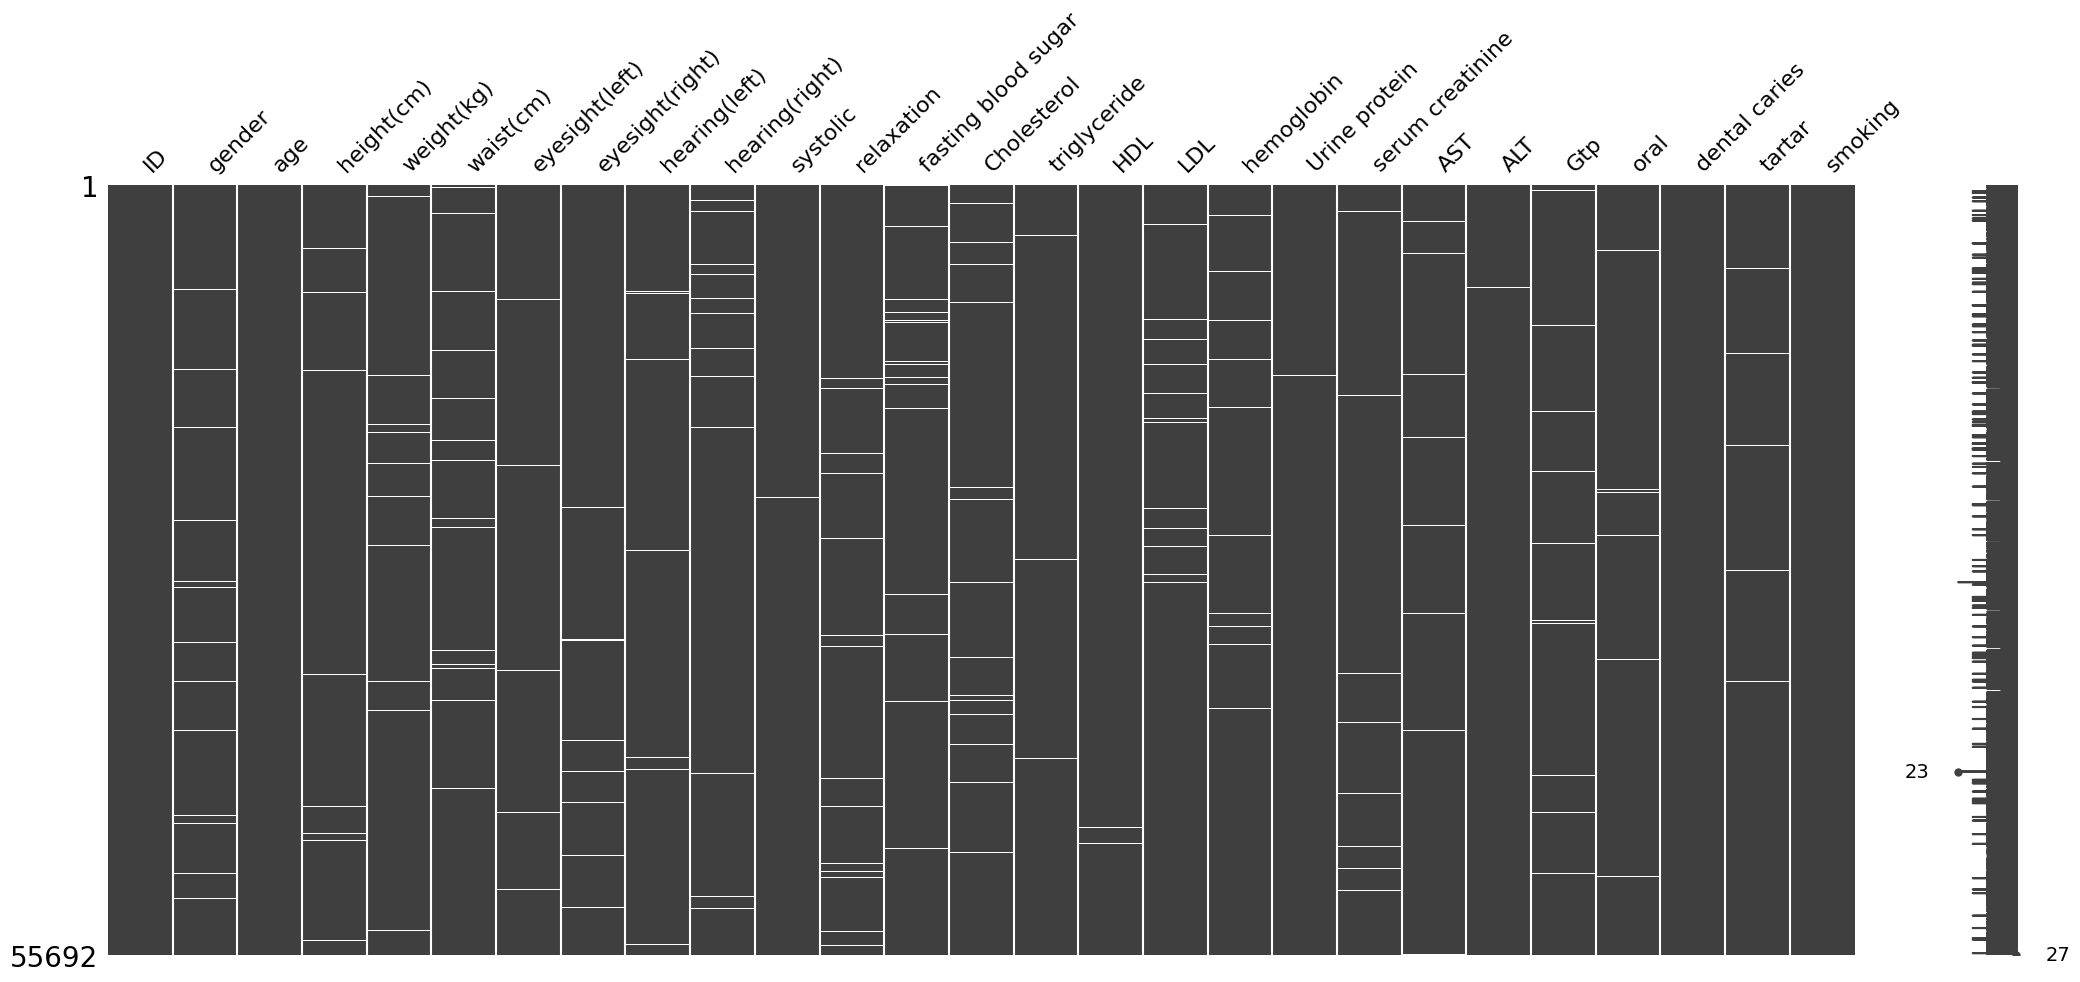

In [ ]:
msno.matrix(dataset)

In [158]:
n = 2  # Set your threshold
num_rows = (dataset.isna().sum(axis=1) > n).sum()
print(f"Number of rows with more than {n} NaN values: {num_rows}")

Number of rows with more than 2 NaN values: 112


In [159]:
dataset = dataset.dropna(axis=0, thresh=len(dataset.columns)-2)

The columns not reported in the figure will be discarded.

For features age and fare the pipeline is composed by two transformers:

KNNImputer: both features contain missing values, so we have to apply an imputation strategy. In this case the strategy is based on the idea of 
k
k-nearest neighbors.
StandardScaler: both features are numerical
For features pclass:

An OrdinalEncoder transforms the strings '3','2' and '1' corresponding to the ticket classes into the numerical values 3,2 and 1.
For features sex and embarked, we apply:

SimpleImputer: feature embarked contains two missing values, while the column sex will be untouched. As a strategy we use 'most_frequent' since both features are categorical
OneHotEncoder: features are categorical.
For features sbsp and parch we define a customer transformer that builds a new feature is_alone indicating whether the passenger travelled alone or not. More details about how to code customer transformers in the following optional section.

For feature name we define a further customer transformer to infer the title (Mr, Miss, Doc, Captain, etc..) from the fullname.

ID: drop
gender: ordinal, 
age: minmax,
oral: ordinal
dental caries: none
tartar: ordinal
O/W: standardization x 20, 


In [160]:
minmax_age = MinMaxScaler()

oe_oral = Pipeline([
        ("pipe_sim", SimpleImputer(strategy="most_frequent")),
        ("pipe_ord",  OrdinalEncoder(categories=[["N","Y"]]))
        ])

oe_tartar = Pipeline([
        ("pipe_sim", SimpleImputer(strategy="most_frequent")),
        ("pipe_ord",  OrdinalEncoder(categories=[["N","Y"]]))
        ])

oe_gender = Pipeline([
        ("pipe_sim", SimpleImputer(strategy="most_frequent")),
        ("pipe_ord", OrdinalEncoder(categories=[["F","M"]]))
        ])

std_body_signals = Pipeline([
        ("pipe_sim", SimpleImputer(strategy="most_frequent")),
        ("pipe_std", StandardScaler())
        ])

In [161]:
# COLUMN TRASFORMATION
body_signals = [
    "height(cm)","weight(kg)","waist(cm)","eyesight(left)","eyesight(right)",
    "hearing(left)","hearing(right)","systolic","relaxation","fasting blood sugar",
    "Cholesterol","triglyceride","HDL","LDL","hemoglobin","Urine protein",
    "serum creatinine","AST","ALT","Gtp"
]

smoking_tr = ColumnTransformer(
    transformers=[
        ("id", "drop", ["ID"]),
        ("gender", oe_gender, ["gender"]),
        ("age", minmax_age, ["age"]),
        ("body_signals", std_body_signals, body_signals),
        ("oral", oe_oral, ["oral"]),
        ("tartar", oe_tartar, ["tartar"])
    ],
    verbose_feature_names_out= False,
    remainder = "passthrough",
    sparse_threshold = 1
)

In [162]:
# Separiamo feature e target columns:
X = dataset.drop(columns=["smoking"])
y = dataset["smoking"]

# Divisione in train e test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,  stratify = y, random_state=42, shuffle=True)

In [163]:
model_pipeline = IMBPipeline([
    ('trans', smoking_tr),
    ('sampler', SMOTE()),
    ('dim_reduction', PCA(n_components=0.8)),
    ('classifier', Perceptron())
])

In [164]:
model_pipeline.fit(X_train,y_train)

Pipeline(steps=[('trans',
                 ColumnTransformer(remainder='passthrough', sparse_threshold=1,
                                   transformers=[('id', 'drop', ['ID']),
                                                 ('gender',
                                                  Pipeline(steps=[('pipe_sim',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('pipe_ord',
                                                                   OrdinalEncoder(categories=[['F',
                                                                                               'M']]))]),
                                                  ['gender']),
                                                 ('age', MinMaxScaler(),
                                                  ['age']),
                                                 ('body_signals',
                                                  Pipeline(steps=[('pipe_sim',
                                                                   SimpleImp...
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('pipe_ord',
                                                                   OrdinalEncoder(categories=[['N',
                                                                                               'Y']]))]),
                                                  ['oral']),
                                                 ('tartar',
                                                  Pipeline(steps=[('pipe_sim',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('pipe_ord',
                                                                   OrdinalEncoder(categories=[['N',
                                                                                               'Y']]))]),
                                                  ['tartar'])],
                                   verbose_feature_names_out=False)),
                ('sampler', SMOTE()), ('dim_reduction', PCA(n_components=0.8)),
                ('classifier', Perceptron())])

In [165]:
model_pipeline.predict(X_test)

array([0, 1, 0, ..., 0, 1, 0])

In [ ]:
X_train = smoking_tr.fit_transform(X_train)
X_test = smoking_tr.fit_transform(X_test)

# Creiamo il modello Random Forest
rf_model = RandomForestClassifier(n_estimators=500, random_state=42, class_weight="balanced")
rf_model.fit(X_train, y_train)

# Effettuiamo predizioni sul test set con Random Forest
y_pred_rf = rf_model.predict(X_test)

# Valutiamo le performance del modello Random Forest
print("Report Random Forest:")
print(classification_report(y_test, y_pred_rf))

print("Matrice di Confusione Random Forest:")
print(confusion_matrix(y_test, y_pred_rf))

print("Accouracy: ", accuracy_score(y_test, y_pred_rf))

Report Random Forest:
              precision    recall  f1-score   support

           0       0.85      0.86      0.86     10550
           1       0.76      0.75      0.75      6124

    accuracy                           0.82     16674
   macro avg       0.81      0.80      0.81     16674
weighted avg       0.82      0.82      0.82     16674

Matrice di Confusione Random Forest:
[[9082 1468]
 [1543 4581]]
Accouracy:  0.8194194554396066


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=77cb4bcc-2fc9-439b-9d91-de217bfdb267' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>